# <center>What is Reinforcement Learning?</center>

<img src="diagram.png" width=400 />

<center>(image credit Wikipedia user Megajuice)</center>

Reinforcement learning (RL) is a branch of machine learning (ML) that is concerned with software based "agents" learning the optimal set of actions to take within a certain "environment". At a fundamental level, the environment is simply an object that accepts actions that move the environment into a new "state" and return any "reward" associated with the new "state". For instance, if the environment is a maze, the agent could attempt to move upwards. This action could result in the agent moving to a new space within the maze, running into a wall, or reaching the end of the maze. These new states may be associated with rewards of 0, -1 (a penalty), and 1 (though this is just one possible reward policy resulting in the agent avoiding walls).

The ultimate goal of the agent is to determine the best actions to take in any given state such that it maximises the potential future reward. In the maze example, for instance, if we give a negative reward for <em>any</em> action that doesn't reach the goal, then the agent would strive to complete the maze in the minimal number of steps. 
    
RL is often considered as a separate ML paradigm from both supervised and unsupervised learning with a key difference being that, at the start of training, there is no training dataset. As the agent begins to interact with the environment it learns the optimal policy through feedback in the form of rewards. In this notebook we will use a particularly useful resource for getting started with RL, the OpenAI Gym!

# <center>OpenAI Gym's Frozen Lake</center>

<img src="openaigym.svg" width=200 />

"OpenAI Gym is a toolkit for developing and comparing reinforcement learning algorithms". There are a number of environments you can play with including an Atari emulator, however the easiest environments are text based. Their simplicity make them ideal for a first introduction to reinforcement learning, so we'll focus on a particular environment called the Frozen Lake. The description from OpenAI gym reads:

"<em> <span style="color:blue">Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.</span></em>"

Let's have a look at the environment:

In [2]:
import gym

env = gym.make('FrozenLake-v0')
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


This is the ASCII representation of the lake where S and G are the starting point and the goal (the location of your wayward frisbee), F are patches of frozen ice that are safe to stand on, and H are holes in the ice. In the parlance of reinforcement learning, each of the 16 positions on the lake are referred to as "states". This ensemble of possible states make up what is referred to as the "observation space". In each state you can attempt to move either left, down, right, or up, which represent the four possible "actions" making up the "action space". The goal is to make your way from the S to the G without landing on an H.

On face value, this may seem trivially easy, however the trick comes in with the "slippery" factor. This is hard coded into the environment and the result is that when you choose a direction in which to attempt your next move, you will either move in that direction or in one of the two directions perpendicular to the chosen direction (or nowhere if that direction is at the boundary), each with equal probability. For example, from the starting position you may like to move to the right you have a 1/3 chance of going right, 1/3 chance of going down, or a 1/3 chance of attempting to go up (and thus not moving anywhere).

Each of the states of the Frozen Lake are assigned a number from 0 to 15 (going from S to G) and actions are assigned numbers as:

Left = 0

Down = 1

Right = 2

Up = 3

We can attempt to move right from the starting position with the following:

In [19]:
env.reset()

action = 2
new_state, reward, done, info = env.step(action)
env.render()

print(new_state, reward, done, info)

  (Right)
SFFF
FHFH
FFFH
HFFG
0 0.0 False {'prob': 0.3333333333333333}


As you can see, taking a step returns four values: new_state, reward, done, and info. <span style="color:red">new_state</span> is the numerical value associated with the new position on the lake after taking the previous action, <span style="color:red">reward</span> is the "reward" you receive for moving into the new state (for the Frozen Lake the goal gives a reward of 1 and all other states a reward of 0), <span style="color:red">done</span> determines if the current episode is completed (this will be False unless you fall in a hole or reach the goal), and <span style="color:red">info</span> tells how likely the move here was given the selected action.

The simplest way to code an agent to try and get through the Frozen Lake is just to simply hard code a specific path to the exit and follow this sequence each time (e.g. right, right, down, down, down, right). Because of the slippery ice, however, this approach succeeds less than 10% of the time. What we really need is a map that tells us what is the best action to take when we find ourselves in any given state. Frozen Lake is pretty simple, so you could probably just come up with such a map fairly easily, but let's do it with AI anyways!

## <center>Q-Learning</center>

The particular type of reinforcement learning we will use is Q-learning. This is a particular type of method well suited to tasks with discrete action spaces. Our Q-learning agent's goal will be to learn the map of optimal actions in each state without any prior knowledge of the movement probabilities of the environment. The basic idea is that, in any given state, each action is assigned a value associated with the expected total future rewards associated with that action. For instance, if we find ourselves directly left of the goal, we might assign a high value to the action "right" and in this sense, being in this space is almost as good as being in the goal. This means that if you are in another space directly next to this penultimate space are also of high value and so on and so on. 

To start, our agent has no knowledge of the environment, it's map is blank meaning at any state there is no preferred action. For this reason, we will start by selecting actions mostly at random in an exploration phase. Eventually the agent will reach the goal, which allows them to update the penultimate state/action pair with a higher preference over other actions. Subsequently, our agent will reach this penultimate space again and it will then increase the preference of the previous state/action pair (which resulted in arrival at the penultimate space). Over time, these preference boosts will trickle up from the goal to the start until the optimal mapping is found (have a look at the figure below and this will make more sense). The agent also takes progressively fewer random actions, and instead rely on our map to choose actions while continuuing to update it. In this way, we shift to a phase that is more focused on producing a high fidelity map around our preferred routes. This type of learning is often referred to as "epsilon-greedy".

In a qualitative sense, the above is all there is to it. In practice, we need to come up with a quantitative method for updating the preference values of each state/action pairs in our map, which we refer to as Q values. This is done using a fairly simple equation (based on the Bellman Equation):

<img src="update.svg" width=800 />

Here the "temporal difference target" is the combination of the current reward and the maximum reward possible from the next state. The new Q value for the current state/action pair is then increased by the current value subtracted from this combined reward. There are two augmentations to this, first the learning rate, alpha (similar to other ML algorithms), and second the "discount factor", gamma. Gamma is a value between 0 and 1 that determines how much future rewards are discounted when calculating the total expected reward. A Gamma of 0 gives a "short sighted" agent who only cares about immediate rewards, while values close to 1 will give more favour to long term rewards.

Now we'll code our Agent as a python class:

In [20]:
class FrozenLakeAgent():
    
    # The only required argument when initializing the agent
    # is the Frozen Lake Environment. We can optionally try
    # different values of alpha and gamma to see how they 
    # affect the agent's learning
    def __init__(self,env,alpha=0.1,gamma=0.99):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        
        # Set the current state to 0, the inital space
        self.state = 0
        
        # The Qtable will be out map of state/action pairs
        # and associate Q values that will allow us to 
        # choose the optimal action in any state. We need
        # to build the table and initialise all the values 
        # to zero. We'll create an object in the dictionary
        # for each of the 16 states and initialize this as
        # an array of 4 zeros, representing the Q value for
        # each action in that state.
        self.Qtable = {}
        for state in range(env.observation_space.n):
            self.Qtable[state] = np.zeros(env.action_space.n)
            
        # ^^ you can access the number of states and actions
        #    using env.observation_space.n and env.action_space.n
        
        
    # Next we have a function to choose the next action which
    # requires an input epsilon value between 0 and 1. As you'll
    # see we choose a random value and choose a random action
    # if it is lower than epsilon. Otherwise we choose the
    # action in the current state that currently has the highest
    # Q value. I like doing it this way so you can experiment
    # with different epsilon curves generated externally to
    # the agent.
    def choose_action(self,epsilon):
        if np.random.uniform() < epsilon:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.Qtable[self.state])
            
        return action
       
    
    # Next we create the learn function that updates the Q
    # value of the current state/action pair. As you will
    # see below, we'll select an action using the above
    # function, pass that to the environment, then get the
    # new state information which is used to update the Q value.
    def learn(self,action,reward,next_state):

        # Current Q value
        old_value = self.Qtable[self.state][action]
        
        # Maximum possible Q value at the next state
        next_max = np.max(self.Qtable[next_state])
        
        # The equation above in python
        self.Qtable[self.state][action] += self.alpha*(reward + (self.gamma*next_max) - old_value)
        
        # Don't forget to update your agent so they know what state they're in!
        self.state = next_state

In [22]:
import numpy as np
#Create the agent
agent = FrozenLakeAgent(env)
for key in agent.Qtable: print(agent.Qtable[key])

[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]


So we can see that the brand new agent has no preferred action in any state. This fresh agent is much like Klink from Hogan's Heros:

<img src="klink.jpeg" width=400 />

OK now we'll set up some of the parameters of our training. Specifically we'll set how many episodes to run and how the value of epsilon (which determines how often to take random actions) evolves over time:

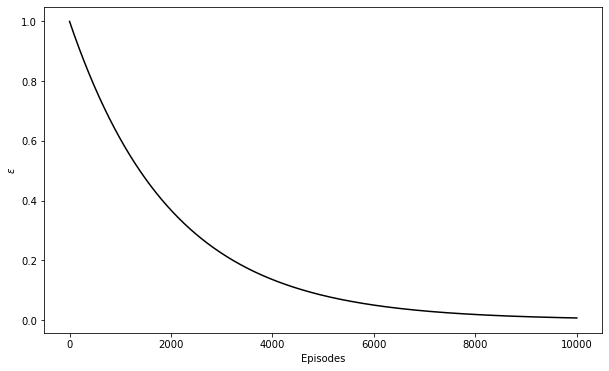

In [24]:
import matplotlib.pyplot as plt

# We'll run it for 10,000 episodes
n_episodes = 10000

# We're also going to use an exponentially declining epsilon value 
# (which determines how random actions are)
episodes = np.linspace(0,n_episodes-1,n_episodes)
epsilons = np.exp(((-1.)*episodes)/2000.)

F = plt.figure(figsize=(10,6))
ax = F.add_subplot(111)
ax.plot(episodes,epsilons,'k-')
ax.set_xlabel('Episodes')
ax.set_ylabel(r'$\epsilon$')
plt.show()

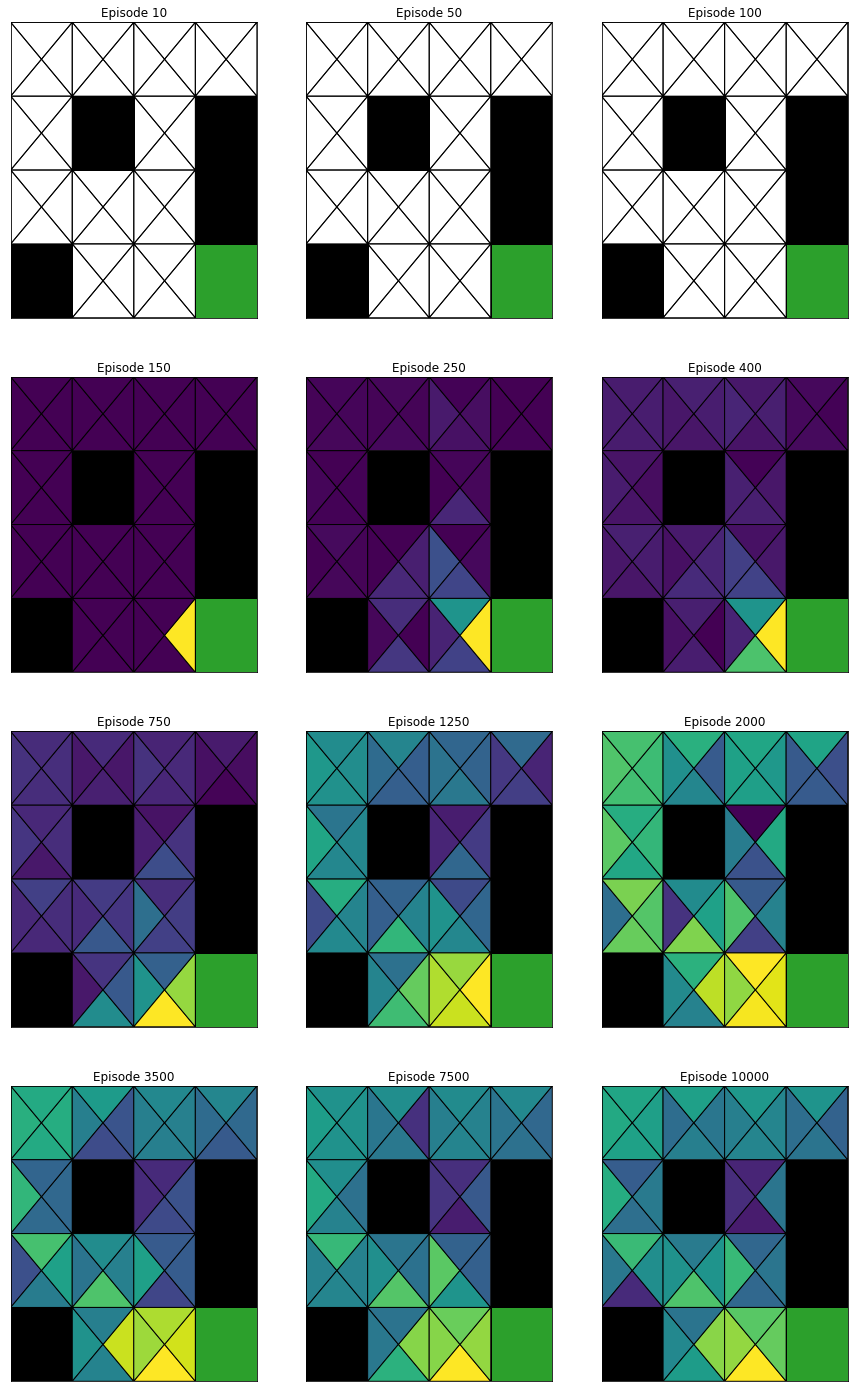

In [27]:
# We'll keep track of the success rate of the previous 20 episodes to see our progress
trailing_20 = []
trailing_eps = []
rewards = []

# I'm also going to load a module that will visualise the Q table as we go
from Qrender import *
eps_to_plot = [9,49,99,149,249,399,749,1249,1999,3499,7499,9999]

# Now create the Agent
agent = FrozenLakeAgent(env,alpha=.2,gamma=.99)

F = plt.figure(figsize=(15,25))
axi = 1
for _episode in range(n_episodes):
    # Resetting for the current episode
    done = False
    state = env.reset()
    agent.state = 0
    
    # Now choose actions till "done" (hole or goal)
    while not done:
        # Choose!
        action = agent.choose_action(epsilons[_episode])
        # Send the action to the environment and get the results
        next_state, reward, done, info = env.step(action)
        # These are now passed back to the agent and the
        # Q value for the action/state pair is updated based
        # on the resulting state
        agent.learn(action,reward,next_state)
        
        if done:
            rewards.append(reward)
            if _episode > 20 and _episode%20 == 0:
                # Calculating the win % of the last 20 episodes
                last_20 = np.array(rewards[-20:])
                wins = np.where(last_20 == 1.)[0]
                trailing_20.append(float(len(wins))/20.)
                trailing_eps.append(_episode)
            if _episode in eps_to_plot:
                ax = F.add_subplot(4,3,axi)
                ax.set_title(f'Episode {_episode+1}')
                Render_Qtable(ax,env.observation_space.n,agent.Qtable)
                ax.set_xticks([])
                ax.set_yticks([])
                axi+=1
                    
plt.show()
            
    

We can see above that at the start, before the agent has managed to reach the goal through random choices, there are essentially no preferred moves at any state. Eventually, however, the agent reaches the goal by taking an action in the penultimate state. The action that was taken at that state immediately recieves a big boost to it's Q value. Later, when the agent reaches the penultimate square, the state/action pair resulting in this also has it's Q value increased (and so on). This is what I meant earlier when I said that the Q values trickle up from the goal to the start, and you can really see that happening in the sequence of Q tables illustrated above.y

Now that we've trained our agent, we can now have a look at the optimal path that it has learned. If we were to let the agent loose on the Frozen Lake environment with epsilon = 0 (no random actions) and with the learning step skipped, then the agent will simply choose the action with highest Q value in any given state. We can also visualise this "optimal policy"

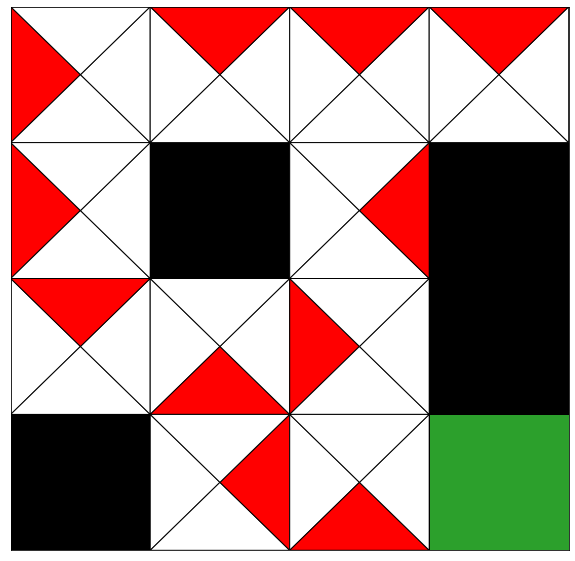

In [28]:
F = plt.figure(figsize=(10,10))
ax = F.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])
Render_Max(ax,env.observation_space.n,agent.Qtable)
plt.show()


The red triangle in each state represents the action the agent will take there. We can see that in general, actions moving directly away from holes are strongly preferred (even when this means attempting to move into a wall!). The only state where this is not true is the third square from the left in the second row from the top (state 6). We see that the optimal action here is to actually go straight into a hole (states 5 or 7)! This makes sense, however, because we know that you actually have a higher probability of not falling in the hole (2/3 chance of going either up or down). As I said, you could probably sit down and come up with this optimal policy based on the fact that you know exactly what the probability of reaching a particular state from a given state/action pair is, but the cool thing here is that our agent has no knowledge of this yet managed to come up with a winning policy.

So how can we be sure that this policy is actually doing a good job? Well we kept track of the win percentage of the last 20 episodes as we went along, so we can simply plot this versus the episode number:

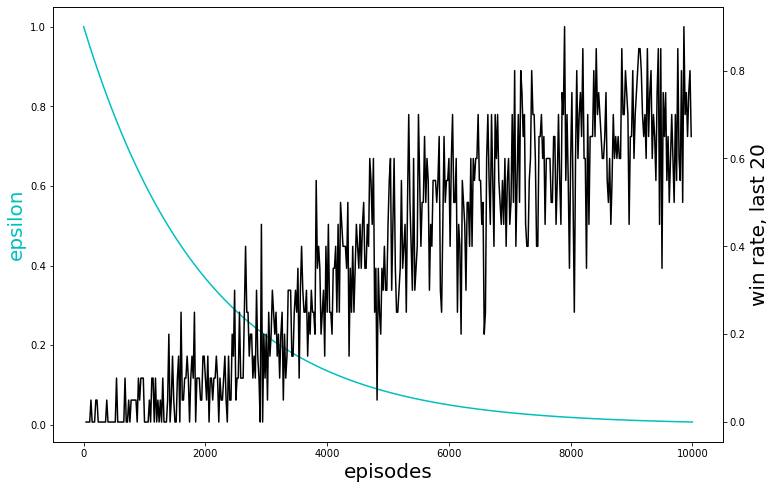

In [31]:
F = plt.figure(figsize=(12,8))
ax = F.add_subplot(111)
ax.plot(episodes,epsilons,'c-')
ax.set_ylabel('epsilon',fontsize=20,color='c')
ax.set_xlabel('episodes',fontsize=20)
xa = ax.twinx()
xa.plot(trailing_eps,trailing_20,'k-')
xa.set_ylabel('win rate, last 20',fontsize=20)
plt.show()

Here black shows the recent win percentage and cyan shows the epsilon value. We see that to start, just taking mostly random actions (large epsilon) results in the agent falling through the ice for the majority of episodes. This doesn't change much until epsilon gets a bit lower and the agent spends more time along the optimal path. This early exploration is <em>key</em> though as it allows the agent time to explore the full observation space and fill out its Q table. Eventually we get up to a win rate of ~70%. Given the probabilstic movements, its unlikely that we can do much better than this. Inevitably, the agent will occasionally end up in state 6, attempt to move directly into the hole at either state 5 (or 7, depends on the training), and actually succeed in doing so (with a probability of 1/3). Based on the optimal policy, though, we can be 100% certain that all failures end up in state 5 (or 7).

This type of Q-learning method is suitable for other problems with discrete observation and action spaces. The majority of the OpenAI Gym environments do not fall into this category and require more sophisticated algorithms that employ neural networks. Our simply agent could also be tested in the Taxi environment, however:

In [32]:
env = gym.make('Taxi-v3')
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In this environment the agent is a taxi driver who is randomly positioned on a 5x5 grid at the start. There are four lettered spaces where passengers can be picked up or dropped off and at the start of each episode a passenger is randomly placed at one (labeled in blue) with a random destination (labeled in pink). There are also barriers (vertical lines) that can not be crossed. The objective is to pick up a passenger and drop them off at a different location in the fewest number of moves. The reward system here is a bit different as well. Any time the agent moves or picks up a passenger a reward of -1 is accumulated, illegal actions (i.e. picking up or dropping off a passenger at a non-lettered location) gives a reward of -10, and successfully dropping off a passenger gives a reward of 20. In this way, achieving the goal with the minimal number of steps is incentivised.

This environment has a much larger observation space (500 states in total) and 2 additional actions (pick-up and drop-off). Another difference, however, is that any action you choose always results in that action being taken (no "slippery" roads), which actually makes this environment much quicker to learn regardless of the larger observation space.

In [33]:
print(f'Observtion Space Size = {env.observation_space.n}')
print(f'Action Space Size = {env.action_space.n}')

Observtion Space Size = 500
Action Space Size = 6


We will have to slightly modify the training loop in this case. In particular, we will keep track of the average reward of the previous 20 episodes rather than the win percentage, which means that we also need to keep track of the cumulative reward <em>during</em> each episode (with the FrozenLake, you only get a reward at the finish). 

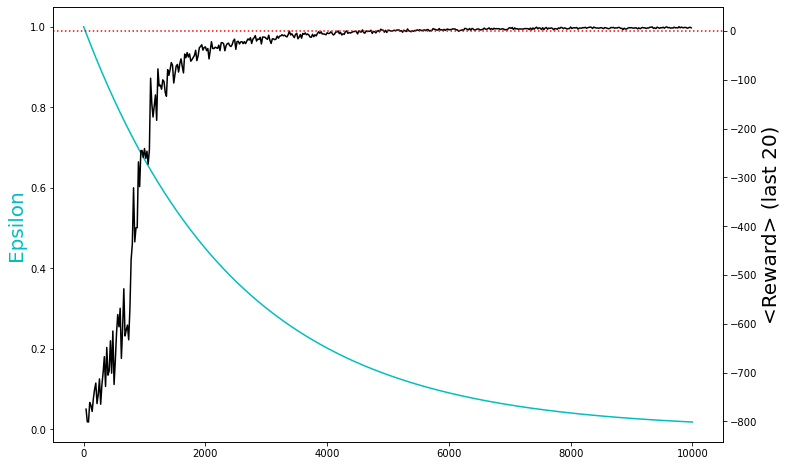

In [34]:
trailing_20 = []
trailing_eps = []
rewards = []

n_episodes = 10000
episodes = np.linspace(0,n_episodes-1,n_episodes)
epsilons = np.exp(((-1.)*episodes)/2500.)
agent = FrozenLakeAgent(env,alpha=.2,gamma=.99)
for _episode in range(n_episodes):
    # Resetting for the current episode
    done = False
    state = env.reset()
    # Because the starting state is random (unlike Frozen Lake)
    # we need to remember to set the starting state correctly
    agent.state = state
    # Initialise the total reward at the start of each episode
    reward = 0
    
    # Now choose actions till "done" (hole or goal)
    while not done:
        # Choose!
        action = agent.choose_action(epsilons[_episode])
        # Send the action to the environment and get the results
        next_state, rwd, done, info = env.step(action)
        # These are now passed back to the agent and the
        # Q value for the action/state pair is updated based
        # on the resulting state
        reward+=rwd
        
        agent.learn(action,reward,next_state)
        
        if done:
            rewards.append(reward)
            if _episode > 20 and _episode%20 == 0:
                # Calculating the average reward of the last 20 episodes
                last_20 = np.array(rewards[-20:])
                trailing_20.append(last_20.mean())
                trailing_eps.append(_episode)
                
F = plt.figure(figsize=(12,8))
ax = F.add_subplot(111)
ax.plot(episodes,epsilons,'c-')
ax.set_ylabel('Epsilon',color='c',fontsize=20)
xa = ax.twinx()
xa.plot(trailing_eps,trailing_20,'k-')
xa.set_ylabel('<Reward> (last 20)',fontsize=20)
xa.set_xlabel('Episode')
xa.axhline(y=0,linestyle=':',color='r')
plt.show()

We see at the start that the agent starts with appalingly low scores. This is primarily due to the fact that in taking random actions, it takes a lot of illegal actions (pickup/dropoff not at the correct locations) generating a reward of -10 for that action. Over time, it learns that these actions should only be performed at specific times, and by episode ~5000 the agent manages to get a positive reward for nearly every episode meaning it is typically able to pick up and drop off the passenger within 20 moves.

Now that we've trained our agent, we can now observe one episode by choosing actions with epsilon fixed at 0 (no random actions) and skipping the learning step. We do need to remember to update the agent's state after each action, however, as this is normally done in the learn step.

In [37]:
done = False
state = env.reset()
agent.state = state
reward = 0
env.render()
while not done:
    action = agent.choose_action(0)
    new_state,rwd,done,info = env.step(action)
    env.render()
    reward+=rwd
    print(f'Reward = {reward}')
    print('')
    if not done:
        agent.state = new_state
    

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Reward = -1

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Reward = -2

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
Reward = -3

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
Reward = -4

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
Reward = -5

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Reward = -6

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
Reward = -7

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Reward = -8

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y|

## <center>Summary</center>

In this notebook, we've created a simply Q-learning agent based on a single equation (the Bellman Equation) that is well suited to learning the optimal actions in environments with discrete action spaces and discrete observation spaces. In a nutshell, the quality of a given action when in a particular state is determined based on the expected future rewards accumulated from future states associated with the results of that action. Our agent begins by choosing actions mostly at random in order to fully sample the observation and action spaces, thus determining (roughly) the quality of all possible actions. Over time, the fraction of actions taken at random is reduced, and instead the agent chooses the expected optimal action with increasing frequency. By focusing on the optimal action space, the optimal pathway is highly sampled resulting in a better fidelity in action choice. 

Among the official OpenAI Gym environments, some other environments fall into this category, including the Atari environments. In this case, however, the observation space is absolutely huge (and you also need to employ convolutional neural networks to interpret the on screen images), so our simple agent will fail miserably. Other than the Frozen Lake and the Taxi environments that we've used here, our agent may be well suited to the other "Toy Text" environments including Blackjack and Roulette, give it a try!

Many of the other OpenAI Gym environments exhibit continuous observation spaces, meaning we can't use the simple agent we created here. For example, the Cart Pole environment challenges your agent to balance a pole on a cart that can be moved either left or right or can stay still (in this case the action space is still discrete). The observations at each state describe the position and velocity of the pole and each episode ends when the pole either leans over too far or the cart leaves the environment (goes too far left or right). In this case, each observations is a set of continuous numbers, so the agent will employ a neural network that determines the optimal action based on these four numbers...

...see the Cart Pole notebook for details...